# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
from IPython.display import Image
PATH = "/Users/Work/Desktop/Work/Projects/Machine Learning Engineer Nanodegree/\
machine-learning-master/projects/finding_donors/"

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = len(data)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = len(data.income[data.income=='>50K'])

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = len(data.income[data.income=='<=50K'])

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k*100/float(n_records)

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

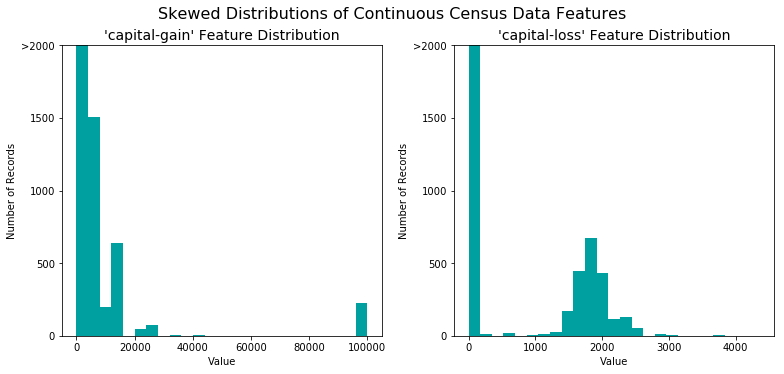

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

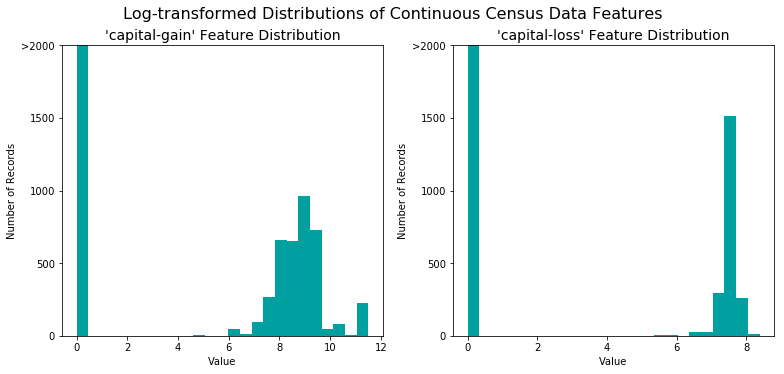

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
f = lambda x: 1 if x=='>50K' else 0
income = income_raw.map(f)
print income.value_counts()

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
#print encoded

0    34014
1    11208
Name: income, dtype: int64
103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [8]:
print n_greater_50k, n_at_most_50k 
#Fβ=(1+β2)⋅precision⋅recall/(β2⋅precision)+recall
#recall = TP/(TP+FN)

11208 34014


In [9]:
# TODO: Calculate accuracy
accuracy = (11208+0)/float(n_records)
precision = (11208/float(11208+34014))
recall = (11208/float((11208+0)))

# TODO: Calculate F-score using the formula above for beta = 0.5
fscore = (1+.5**2)*precision*recall/float(((.5**2)*precision)+recall)
# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


<font color='red'>  The accuracy score is 24.78%.  The F-beta score is 29.17%.  The F-beta score is low because we are emphasizing precision, so even with a recall of 1, the precision of only 24.78% is bringing the metric down.  Notice that the F-beta score is slightly higher than the accuracy score, since the recall of 1 is considered in the metric.

###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **
<font color='red'> 
**K-Nearest Neighbors Classifier (KNN)** <br>
1.  Researchers have predicted with 76% accuracy using the KNN classifier whether a kickstarter project (https://www.kickstarter.com) will succeed several hours after it launches.  After several days after the project launches, the KNN model predicts with about 85% accuracy whether the project will succeed.  The model is fed Twitter tweets that mention the kickstarter project, as well as financial information (source 1).  <br>
2. KNN is simple to implement and few parameters require tuning (just the distance measure and k).  <br> It is robust to noise in the data, hence overfitting is less of a problem (source 2,4,5,6).
3.  It is slow when there are many training examples.  More observations are needed as the number of features increases in order for model performance to be good, due to the model being especially susceptible to the curse of dimensionality  (source 2, 3) . 
<br> 
5. The K-Nearest Neighbors algorithm can be used for regression or classification problems.   Since we've got a classification problem, it is suitable.
<br><br>
(1) https://arstechnica.com/business/2013/10/statistical-models-can-predict-a-kickstarters-success-within-4-hours/ <br>
(2) http://www.cs.upc.edu/~bejar/apren/docum/trans/03d-algind-knn-eng.pdf <br>
(3) http://research.cs.tamu.edu/prism/lectures/pr/pr_l8.pdf <br>
(4) http://people.revoledu.com/kardi/tutorial/KNN/Strength%20and%20Weakness.htm <br>
(5) http://www.nickgillian.com/wiki/pmwiki.php/GRT/KNN <br>
(6) https://en.wikibooks.org/wiki/Data_Mining_Algorithms_In_R/Classification/kNN <br>

<br>
**Support Vector Machines (SVM)**:
1. SVMs, among other machine learning algorithms, are being used to identify cases of online harassment.  The SVM is trained off messages so it can differentiate between a message containing non-abusive text and a message containing abusive text (source 1).   <br>
2. SVMs are robust to noise in the data, hence overfitting is less of a problem.  <br>   Predictions have high accuracy (source 2,3).
3. SVMs are slow in both training and predicting (they take awhile to run) (source 3). <br>
 Several model parameters must be selected correctly or else model prediction accuracy could be poor (source 4). 
4.  This problem is a binary classification problem, which SVMs are suitable for.
<br>

(1) http://theconversation.com/ai-can-help-silence-the-trolls-but-tackling-online-abuse-is-ultimately-a-human-choice-48399 <br>
(2) http://www.cs.uky.edu/~jzhang/CS689/PPDM-Chapter2.pdf <br>
(3) http://condor.depaul.edu/ntomuro/courses/578/notes/SVM-overview.pdf <br>
(4) http://www.nickgillian.com/wiki/pmwiki.php/GRT/SVM <br>

**Adaboost Classifier**:
1. Adaboost has been used in facial detection algorithms for cameras.  Adaboost trains off data containing thousands of features associated with faces and non-faces and then is able to predict when a human face is being captured by the camera and when it isn't (source 3).
2.  Adaboost does well without hyperparameter tuning.  You just need to select the weak learner to use for it and the number of boosting rounds (the number of times to employ the weak learner).  Adaboost is fast (source 1,2).
3.  Adaboost is sensitive to noise and outliers.  Selecting a weak learner that is too complex can lead to overfitting, meaning the model won't generalize well (source 1).
4.  This problem is a classification problem.  Since the Adaboost Classifier handles classification problems, it is suitable.  

(1) http://math.mit.edu/~rothvoss/18.304.3PM/Presentations/1-Eric-Boosting304FinalRpdf.pdf <br>
(2) http://www.nickgillian.com/wiki/pmwiki.php/GRT/AdaBoost <br>
(3) http://www.azosensors.com/article.aspx?ArticleID=653

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [10]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() #Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end-start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end-start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta=.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

KNeighborsClassifier trained on 452 samples.
KNeighborsClassifier trained on 4522 samples.
KNeighborsClassifier trained on 45222 samples.


/Users/Work/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 452 samples.
SVC trained on 4522 samples.
SVC trained on 45222 samples.
AdaBoostClassifier trained on 452 samples.
AdaBoostClassifier trained on 4522 samples.
AdaBoostClassifier trained on 45222 samples.


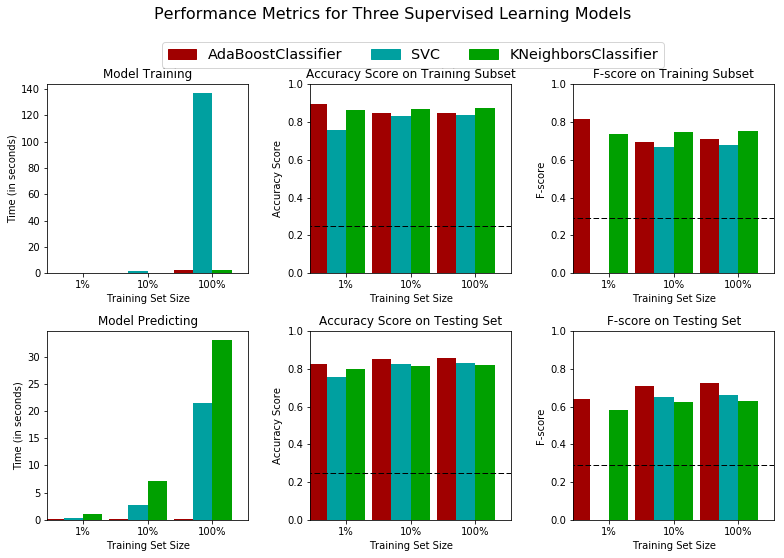

In [12]:
# TODO: Import the three supervised learning models from sklearn
import sklearn
from sklearn.tree import DecisionTreeClassifier
# TODO: Initialize the three models
clf_A = sklearn.neighbors.KNeighborsClassifier()
clf_B = sklearn.svm.SVC(random_state=0)
dtc=DecisionTreeClassifier(max_depth=1,random_state=0)
clf_C = sklearn.ensemble.AdaBoostClassifier(base_estimator=dtc,random_state=0)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(round(n_records*.01,0))
samples_10 = int(round(n_records*.1,0))
samples_100 = n_records

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = [0,0,0]  #original code: results[clf_name] = {train_predict(clf_A)}    
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)
        
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

<font color='red'> 
Below, I show the confusion matrix and verify that manually calculating the precision from the confusion matrix is equal to the value calculated from sklearn's precision score function. 

Precision: 0.763
Recall: 0.604
Accuracy: 0.858
F-beta Score: 0.725
True


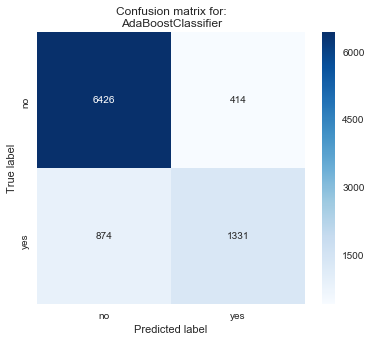

In [68]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Compute confusion matrix for a model
model = clf_C
cm = confusion_matrix(y_test, model.predict(X_test))

# view with a heatmap
plt.rcParams['figure.figsize']=(6,5)
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'],fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__))
print 'Precision: %r'  %round(precision_score(y_test,model.predict(X_test)),3)
print 'Recall: %r'     %round(recall_score(y_test,model.predict(X_test)),3)
print 'Accuracy: %r'   %round(accuracy_score(y_test,model.predict(X_test)),3)
print 'F-beta Score: %r'   %round(fbeta_score(y_test,model.predict(X_test),beta=.5),3)
print precision_score(y_test,model.predict(X_test))==1331/float(1331+414);

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: ** <br>
<font color='red'> Regarding model training and testing time, the AdaBoost Classifier wins hands down.  All models took almost no time to train off the data (for all sample sizes), except for SVC on the sample size of 100% of training data, which took over a minute.  In making predictions on the testing data, AdaBoost took less than a few seconds for all training set sizes.  SVC and KNN took longer as the training set size increased (nearly 30 seconds for a training set size of 100% of all training examples).   <br>

Regarding the accuracy metric, AdaBoost offers the best predictive accuracy for all training set sizes on the testing set and achieves just over 80% accuracy on all training set sizes.  The accuracy metric is the number of correctly labeled instances over all predicted instances.  So about 80% of testing examples were correctly labeled/identified, so the formula is: <br>(correctly identified over-50K examples and correctly identified under-50K examples divided by all predicted examples). AdaBoost accuracy on the training subset is also around 80%.  Although AdaBoost only offers the highest accuracy on the smallest training set size in making predictions on the training set, we just care about AdaBoost's ability to make predictions on NEW data.  We care about AdaBoost's ability to generalize to data the model has not been trained on, since this is what the model was built to do (make predictions on new data), so the fact that AdaBoost has the highest predictive accuracy on the test data makes AdaBoost the number 1 model in regards to optimizing the Accuracy metric (disregarding any effect from tuning hyperparameters for each model, which we have not yet done).  
<br>

Regarding the F-beta score metric, AdaBoost offers the best F-score for all training set sizes on the testing set.  Just like the accuracy metric, we care about the F-score on the TEST set and not the training set.  The F-beta score is important to assess in addition to the accuracy metric because it offers a measurement of recall and precision with a heavier weighting on precision (due to beta=.5), since that is what we care about.  The accuracy metric of 80% tells us that the model is doing well, but it doesn't tell us about precision and recall.  The F-beta score tells us about BOTH precision and recall but with more information on precision.  We then consult the F-beta score and compare it with other models to see if, even though the model is doing well, is it doing well in the particular way that we would like (having good precision)? It is more important that the model requests donations from people that are more likely to donate (precision) than the model requesting donations from the most number of people that are likely to donate (recall).  If donations are requested based on the model's predictions, then donations will be requested from x% of >50K people, but of all requested donations, y% of them will actually be towards those with over 50K in income.  We care about y% more than x%, where y% is precision and x% is recall.  

Accuracy doesn't provide enough information about precision because you can still have great accuracy even with a poor y% (precision), especially in the scenario where most people have under 50K of income and you make a model where all people are predicted as having under 50K of income (in which case you wouldn't be requesting anyone for donations, which renders the exercise pointless, even though the accuracy will be high).  

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **  <br>
<font color='red'> 

AdaBoost takes a model and enhances it ("boost"s it) by building a series of alterations of the model off the data. Each subsequent time the model is constructed, it is altered to focus more on the data that it predicted incorrectly the previous time it was built (the model is "ada"pted to the data).  AdaBoost then averages the predictions of all of the models and gives greater consideration to models that gave more accurate predictions.  <br>

See the diagrams below.  Going from left to right, each box represents the subsequent model produced from AdaBoost.  Observations are labeled with + or -.  We're trying to predict these labels.  AdaBoost predicts whether each of the 10 observations will have a + or a - label by dividing up the region into red and blue shaded areas.  If a symbol falls within the blue shaded area, the model predicts it as having a + label.  If a symbol falls within the red shaded area, the model predicts it as having a - symbol.  


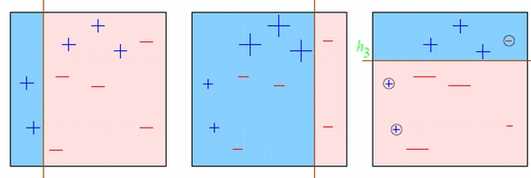

In [13]:
Image(filename = PATH + "boosting_picture.jpg", width=500, height=50)

<font color='red'> In the first model (on the left), three + labels are incorrectly predicted because they are in the red region.  The second model then focuses on these incorrectly predicted + labels.  Notice how they are bigger, meaning the model gives them greater consideration in forming the blue and red shaded regions.  The third model notices that three - labels are incorrectly predicted in the second model, so it gives them greater consideration and divides up the regions in a way so that the three - labeled observations are predicted correctly.  AdaBoost then averages the results of all three models to arrive at a final prediction for each observation.


**primary sources**:Udacity, http://machinelearningmastery.com/boosting-and-adaboost-for-machine-learning/<br>



<font color='red'>**Here's a creative way of describing AdaBoost.**

Assume the variable to be predicted is whether or not you'll like a certain music band.  You give your friend a list of bands you like and don't like.  Your friend then comes up with a series of questions based on having seen this list.    They construct the questions such that, based on your answers to them, they predict whether or not you'll like any given music band.  The questions are like a Decision Tree model.  The list of bands you like and don't like, and the qualities about those bands that are apparent to your friend, is like the data.  
<br>

Your friend asks the questions for each band in the list of bands you provided.  They correctly predict that you'll like some bands and incorrectly predict that you'll like others.  Your friend then revises the list of questions so that when they ask the questions again on the list of bands you gave them, they'll correctly predict more of the bands that they had incorrectly predicted before.  This second list of questions is like model #2.  Your friend keeps asking you questions and revising their questions so that more and more, they focus on correctly predicting bands that they had predicted incorrectly in their previous round of question asking.  Eventually, your friend takes all of the lists of questions, and averages their answers by giving more weight to the question lists that did better at predicting. For a given band, your friend uses the averaged answer to guess whether or not you'll like that band.
Thus, your friend uses an AdaBoost-like procedure to "boost" their original list of questions in a way that is "ada"ptive to the data so as to improve upon their original list of questions.

**The above interpretation was inspired by the following blog post** <br>
http://blog.echen.me/2011/03/14/laymans-introduction-to-random-forests/


### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [24]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
dtc=DecisionTreeClassifier(max_depth=1,random_state=0)
clf = sklearn.ensemble.AdaBoostClassifier(base_estimator=dtc,random_state=0)

# TODO: Create the parameters list you wish to tune
parameters = {'base_estimator__max_depth':[1,10,30,50],
              "n_estimators": np.arange(50,71,1)}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring = scorer)

#We could have also done K-Fold cross validation to tune the hyperparameters.
#cv = cross_validation.StratifiedShuffleSplit(labels, 100, random_state = 42)
#grid_obj = GridSearchCV(clf, param_grid = clf_params,cv = cv, scoring = 'recall')
    
    
# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8600
Final F-score on the testing data: 0.7303


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |   <font color='red'>    <font color='red'> <font color='red'> 0.2478               |  <font color='red'>   .8576               |<font color='red'>  .8600                |
| F-score        |     <font color='red'>  0.2917               |   <font color='red'>   .7246              | <font color='red'>  .7303       |


**Answer: ** <br>
<font color='red'>The optimized model has slightly better accuracy and F-scores than the unoptimized model, as shown above.  Both models have better scores than the benchmark predictor where we predicted all examples as having over 50K in income.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:**

<font color='red'>
These five, ranked features will likely be predictive in my opinion (where 1 is the most predictive): <br>
1.  occupation
2.  education_num
3.  education_level
3.  age
4.  sex
5.  race

<br>
Someone with a white-collar occupation (lawyers, doctors, data scientists) should see a huge difference in income compared with someone with a blue-collar occupation (janitor, bus driver), regardless of other variables like education, age, sex, race etc.  A white collar job that is high paying is by definition, going to result in someone having a higher income than a blue collar job that is low paying.<br>

Education level, such as phd vs masters vs bachelors vs etc should see fairly large differences in average income.  I do not expect education to be as predictive as occupation, since getting a phd (for instance) doesn't necessarily translate to more income, especially if someone majors in a "soft" major, like philosophy or religion.  I would expect education_level and education-num to offer similar levels of predictability, though education-num provides more information, since it's quantitative, so perhaps is the more important predictor.  
<br>
My intuition is telling me that education is a more significant predictor than age.  Age, in this case, would generally reflect years of experience in a career, and more years means more money (unless we've got a career changer on our hands).  I would guess education to generally offer greater increases in salary than age/career experience, especially when comparing the change in income for high school vs bachelors and above to the change in income, for example, from a 25 year old to a 35 year old, holding all else constant.  Many high paying occupations require more than a high school diploma, so having 10 years more experience with only a high school diploma (as measured by being 10 years older) would not result in having a higher paying job if that job requires more than just a high school diploma.    
<br>
I would expect age to be a more significant predictor of income than sex, since more years of experience, as measured by age, would mean more knowledge, skills and thus, income.  There is no change in knowledge or skills if you gender is changed from female to male, while there IS a change in knowledge and skills if years of experience/age is changed from 1 to 10 (assuming careers aren't changed).  Changes in income associated with sex is a result of the gender pay gap and glass ceiling, which is unfortunate, but I would not expect this change to be as large as the change in income resulting from having more years of experience.
<br>

Finally, I would expect, based on intuition, that gender is a greater predictor of income than race.  I recall reading that the gender pay gap is bigger than differences in income stemming from race.  I have included race because I have seen before in news articles and studies that race impacts income, due to a variety of factors.



<font color='red'>
I verify that gender does indeed result in a pay gap, shown below,.  Observe that 45.4% of males have incomes above 50k, while only 12.8% of females have incomes above 50k.  This was calculated from the cross tabulation table of sex vs income.  This is not controlling for other factors though, like education and occupation.  If more males have a higher education and higher paying jobs, then this also explains the apparent gender gap in income.

I also verify that education level appears to result in a pay gap (cross tabulations are shown below): <br>
7.45 percent of high school grads have income over 50k<br>
41.98 percent of bachelors grads have income over 50k<br>
55.41 percent of masters grads have income over 50k

In [115]:
f = lambda x: 1 if x==' Male' else 0
sex=data['sex']
sex_new = sex.map(f)
explore=data.drop('income',axis=1).drop('sex',axis=1)
explore['income']=income
explore['sex']=sex_new
pd.crosstab(explore.sex,explore.income)
print '%r percent of females have income above 50k.' %(round(1669*100/float(13026+1669),1))
print '%r percent of males have income above 50k.' %(round(9539*100/float(20988+9539),1))

income,0,1
sex,,
0,13026,1669
1,20988,9539


11.4 percent of females have income above 50k.
31.2 percent of males have income above 50k.


In [122]:
features_explore=features.assign(income=income)
pd.crosstab(features_explore['education_level_ 12th'],features_explore.income)
pd.crosstab(features_explore['education_level_ Bachelors'],features_explore.income)
pd.crosstab(features_explore['education_level_ Masters'],features_explore.income)
print '%r percent of high school grads have income over 50k' %(round(43*100/float(534+43),2))
print '%r percent of bachelors grads have income over 50k' %(round(3178*100/float(4392+3178),2))
print '%r percent of masters grads have income over 50k' %(round(1393*100/float(1121+1393),2))

income,0,1
education_level_ 12th,,
0,33480,11165
1,534,43


income,0,1
education_level_ Bachelors,,
0,29622,8030
1,4392,3178


income,0,1
education_level_ Masters,,
0,32893,9815
1,1121,1393


7.45 percent of high school grads have income over 50k
41.98 percent of bachelors grads have income over 50k
55.41 percent of masters grads have income over 50k


### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

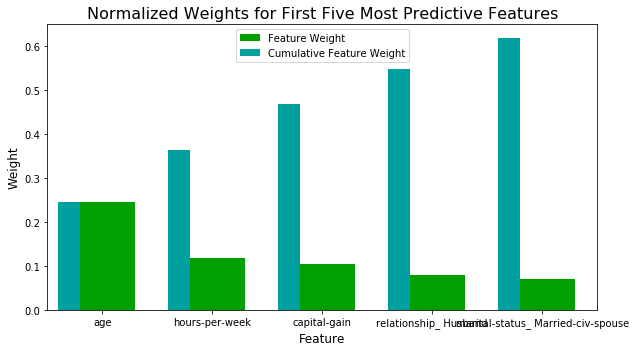

In [130]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier
# TODO: Train the supervised model on the training set 
model = RandomForestClassifier(random_state=0).fit(X_train,y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:** <br>
<font color='red'>
The most important features in the random forest classifier are (in descending order): <br>
1. age <br>
2. hours-per-week<br>
3. capital-gain <br>
4. relationship_ Husband<br>
5. marital-status_ Married-civ-spouse<br>
<br>

These results were a complete surprise.  The only feature that I predicted correctly as belonging to the top 5 was 'age'.  Perhaps 'hours-per-week' makes sense as being the second most relevant variable because higher income people tend to work longer hours.  I was against this logic initially since working longer hours could also mean 1) poor time management and not being efficient enough to get things done in a timelier fashion 2) a desperate employee trying to keep their job, etc...  Since most people with incomes above a certain amount (like above 30k) are salaried employees, working longer hours does not automatically mean making more money, so this would not be a good reason behind why longer hours means more income. For this variable to be more relevant than education surprises me.  

The fact that capital-gains is important makes sense, now that I think about it.  Assuming capital gains is included in the definition of income, then literally, as capital gains increases, income increases (assuming capital gains are included in the definition of income, and the likelihood that income>50K increases.  This is actually a no-brainer.  I suspect that capital-gain isn't ranked higher because of its right-skewed distribution. Most people don't have capital-gains, so this variable provides less information because of this fact. <br>

'relationship\_ Husband' as an important variable is an interesting result.  It might make sense as being super relevant from the standpoint of mate selection.  Men that earn more money are more desirable as partners, all else held constant, so the fact that a person is a husband reflects positive qualities about that man as perceived by his partner, which resulted in his partner choosing him as a partner.  This fact, in part, likely stems from the fact that the man makes more money and has other potential qualities needed to make more money (soft skills, intelligence, etc).  My comments above assume that the person is a man when 'relationship\_ Husband' is true.  In the census.csv, there is one observation where the sex is female when the relationship value is 'relationship\_ Husband'.  Oops or not oops?

'marital-status\_ Married-civ-spouse' as an important variable is also an interesting result.  As shown below, 45.42% of married people have over 50k in income, while only 6.8% of unmarried people have over 50k in income.  However, the below result does not control for other factors, like age, and thus could be due to the fact that unmarried people are typically younger and younger people make less money.  Perhaps married people make more money for the same reasons as the 'relationship\_ Husband' variable--that more desirable people tend to mate and part of this desirability consists of qualities desired by employers.

In [142]:
pd.crosstab(features_explore['marital-status_ Married-civ-spouse'],features_explore.income)
print '%r percent of married people have income over 50k' %(round(9564*100/float(9564+11491),2))
print '%r percent of unmarried people have income over 50k' %(round(1644*100/float(1644+22523),2))

income,0,1
marital-status_ Married-civ-spouse,,
0,22523,1644
1,11491,9564


45.42 percent of married people have income over 50k
6.8 percent of unmarried people have income over 50k


### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [143]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8600
F-score on testing data: 0.7303

Final Model trained on reduced data
------
Accuracy on testing data: 0.8178
F-score on testing data: 0.6267


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**
<font color='red'>
The accuracy and F-beta-score drop by .0422 and .104, respectively.  The training time was not very long to begin with, so I would not want to sacrifice the drop in the F-beta score (with an emphasis on precision, which is what we care about more) of .104  to reduce the training time just a little bit.  If the training time was very long to begin with, and we were constantly getting new data that we wanted to re-fit the model on, then the data reduction might be warranted so that we could process new donor prospects and reach out to them in a timelier fashion.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.